In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord,SphericalDifferential,ICRS,Galactic,GalacticLSR,Distance
import pandas as pd
from astropy.table import Table, join,vstack
import numpy as np
from scipy import interpolate
import math
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from scipy import ndimage
from scipy import signal
from scipy.ndimage import gaussian_filter1d
import healpy as hp
from tqdm import tqdm

# Edenhofer Map

In [12]:
# f=fits.open('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/edenhofer_2023/mean_and_std_xyz.fits')
# dust_map = f[1].data
# f[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1251                                                  
NAXIS2  =                 1251                                                  
NAXIS3  =                 1251                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'MEAN    '           / extension name                                 
CTYPE1  = 'X       '                                                            
CUNIT1  = 'pc      '                                                            
CDELT1  =                  2.0                                                  
CRVAL1  =                -12

# Cutting the map around the Gum Nebula region

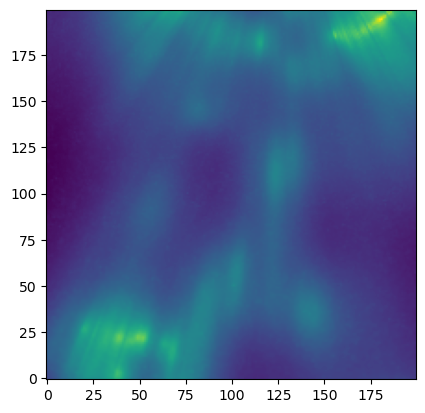

In [241]:
plt.imshow(np.log(dust_map[625,350:550,500:700]),origin='lower') #z: 520, 720

In [48]:
gum_dust_map=dust_map[460:740, 280:560, 480:760]

In [45]:
gum_dust_map.shape

(280, 280, 280)

In [49]:
f[1].header['NAXIS1'] = 280
f[1].header['NAXIS2'] = 280
f[1].header['NAXIS3'] = 280
f[1].header['CRVAL1'] = 480*2-1250
f[1].header['CRVAL2'] = 280*2-1250
f[1].header['CRVAL3'] = 460*2-1250

In [50]:
hdu = fits.PrimaryHDU(gum_dust_map, header=f[1].header)
hdul = fits.HDUList([hdu])
hdul.writeto('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/edenhofer_2023/gum_dust_map.fits')

# Sketch inner shell

## <font color= '1E90FF'> Sketch based on Center0 </font>

In [9]:
line1 = pd.read_csv('/Volumes/ROCKET-nano/dustmaps_files/Dust_maps/Edenhofer_map_sketch/density_lines_edenhofer_Gum.csv')

In [2]:
# plt.imshow(np.nansum(dust_map,axis=2),origin='lower',vmax=0.1)

In [42]:
ip=np.arange(0,196608, 5)
NSIDE = 128
theta, phi = hp.pix2ang(nside=NSIDE, ipix=ip)
# center of Gum Nebula:
x_G = -54.864 #pc
y_G = -329.738 #pc
z_G = -64.234 #pc
# To pixel: 
stepsize=1079/300
r = 200/stepsize
xG_p = (300+x_G/stepsize) 
yG_p = (300+y_G/stepsize)
zG_p = (300+z_G/stepsize)
p_x = xG_p + r* np.sin(theta)* np.cos(phi) 
p_y = yG_p + r* np.sin(theta)*np.sin(phi) 
p_z = zG_p + r* np.cos(theta)
# fn = '/Volumes/ROCKET-nano/dustmaps_files/Dust_maps/Edenhofer_map_sketch/xyz_Gum_edenhofer.npz'

## <font color= '1E90FF'> Sketch based on Center1 </font>

### <font color='9357C2'> Old dust map </font>

In [3]:
ip=np.arange(0,196608, 5)
NSIDE = 128
theta, phi = hp.pix2ang(nside=NSIDE, ipix=ip)
# center of Gum Nebula:
x_G = -67 #pc
y_G = -334 #pc
z_G = -65 #pc
# To pixel: 
stepsize=1079/300
r = 350/stepsize #200/stepsize
xG_p = (300+x_G/stepsize) 
yG_p = (300+y_G/stepsize)
zG_p = (300+z_G/stepsize)
p_x = xG_p + r* np.sin(theta)* np.cos(phi) 
p_y = yG_p + r* np.sin(theta)*np.sin(phi) 
p_z = zG_p + r* np.cos(theta)
# fn = '/Volumes/ROCKET-nano/dustmaps_files/Dust_maps/Edenhofer_map_sketch/xyz2_Gum_edenhofer_350.npz'
# np.savez(fn, p_x=p_x, p_y=p_y, p_z=p_z)

### <font color='9357C2'> Updated cutted dust map </font>

In [2]:
f=fits.open('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/edenhofer_2023/gum_dust_map.fits')
dust_map = f[0].data
# f[0].header

In [2]:
ip= np.arange(0,196608) #np.arange(0,196608, 5)
NSIDE = 128
theta, phi = hp.pix2ang(nside=NSIDE, ipix=ip)
# center of Gum Nebula:
x_G = -67 #pc
y_G = -334 #pc
z_G = -65 #pc
# To pixel: 
stepsize=2
r = 350/stepsize 
xG_p = (145+x_G/stepsize) 
yG_p = (345+y_G/stepsize)
zG_p = (165+z_G/stepsize)
p_x = xG_p + r* np.sin(theta)* np.cos(phi)
p_y = yG_p + r* np.sin(theta)*np.sin(phi) 
p_z = zG_p + r* np.cos(theta)
# fn = '/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/xyz2_Gum_edenhofer_350_cut.npz'
# np.savez(fn, p_x=p_x, p_y=p_y, p_z=p_z)

In [13]:
# sphere_point = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/xyz2_Gum_edenhofer_350_cut.npz')

In [3]:
loc = np.zeros((len(p_x), 3, 350))
for w in range(len(p_x)):
    loc[w, 0, :] = np.linspace(zG_p, p_z[w], 350)
    loc[w, 1, :] = np.linspace(yG_p, p_y[w], 350)
    loc[w, 2, :] = np.linspace(xG_p, p_x[w], 350)

In [10]:
def compute_column(i, loc):
    return i, ndimage.map_coordinates(dust_map, loc, order=1)

In [15]:
b = np.zeros((350, len(p_x)))
results = [compute_column(i, loc[i, :, :]) for i in tqdm(range(len(p_x)))]

100%|██████████████████████████████████| 196608/196608 [23:58<00:00, 136.66it/s]


In [16]:
for i, column in results:
    b[:, i] = column
pd.DataFrame(b).to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/density_lines_edenhofer_Gum_2_350_cut.csv', index=False)

## Use density lines

data: unit [E] \
Convert to A_G using the extinction table: $A_{G} = data*2.040684938430786 [mag]$ \
Convert to column density: use relation $\frac{A_{G}}{N_{H}} = 4*10^{-22} cm^{2}*mag $ \
$N_{H} = \frac{A_{G}}{4* 10^{-22} cm^{2}* mag} = \frac{data*2.040684938430786}{4*10^{-22}} [cm^{-2}]$ \
Length of a cell: $2pc = 2*3.0857*10^{18}cm$ \
Meaning that the column density(unit: $cm^{-2}$) is in fact a volume of $V_{0}=1cm^{2}*2pc = 2*3.0857*10^{18} cm^3 $ \
volume density: $n_{H}=\frac{N_H}{V_{0}} = \frac{data*2.040684938430786}{4*10^{-22}*2*3.0857*10^{18}} [cm^{-3}] = data *826.67 [cm^{-3}]$

###  <font color= '1E90FF'>  Old density lines </font>

In [27]:
line2_orig = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/old_dustmap/density_lines_edenhofer_Gum_2_350.csv')
line2 = line2_orig*826.670

In [7]:
loc = np.zeros((len(p_x), 3, 195)) # to make sure that the resolution=1/2 of the map resolution
for w in range(len(p_x)):
    loc[w, 0, :] = np.linspace(zG_p, p_z[w], 195)
    loc[w, 1, :] = np.linspace(yG_p, p_y[w], 195)
    loc[w, 2, :] = np.linspace(xG_p, p_x[w], 195)

###  <font color= '1E90FF'>  Updated density lines </font>

In [4]:
# interpo = ndimage.map_coordinates(dust_map,loc[100, :, :], order=1)
density_lines_orig = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/density_lines_edenhofer_Gum_2_350_cut.csv')
density_lines = density_lines_orig*826.670

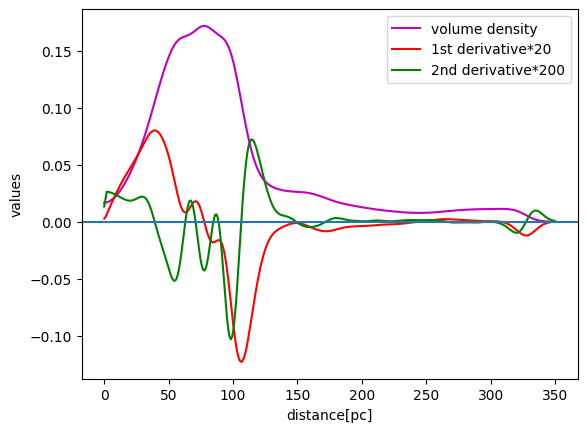

In [6]:
# sigma = 7.42857
# p = 177620
# x1 = loc[p, 2, :]- xG_p
# y1 = loc[p, 1, :]- yG_p
# z1 = loc[p, 0, :]- zG_p
# dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
# gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
# d1 = np.gradient(gau_1D_dens, dist)
# d2 = np.gradient(d1,dist)
# gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
# d1 = np.gradient(gau_1D_dens, dist)
# d2 = np.gradient(d1,dist)

# plt.plot(dist, gau_1D_dens, 'm', label='volume density')
# plt.plot(dist, d1*20, 'r', label='1st derivative*20')
# plt.plot(dist, d2*200, 'g', label='2nd derivative*200')

# plt.axhline(0)

# # plt.scatter(inner.iloc[p]['r_raw'], 0, label='inner boundary distance')
# # plt.scatter(outer.iloc[p]['r_raw'], 0, label='outer boundary distance')
# plt.xlabel('distance[pc]')
# plt.ylabel('values')
# plt.legend()
# # plt.grid()
# plt.show()

## Use iterative method to find Gum nebula geometry
####  <font color= '1E90FF'> So that it finds a well-defined dense dust region </font> 
The aim to start from a large smoothing factor sigma, and gradually tighten it. \
Use large smoothing factor to find the big obvious dense dust region that has a clear shape. 
And use small smoothing factor to get close to the dense region to better define its inner and outer boundary. \
Standard to stop: whether it is robust enough. Think about the definition of the boundary. Compare with history plots.

## <font color='9357C2'> Based on old density lines </font>

In [118]:
np.linspace(350, 700, 5)

array([350. , 437.5, 525. , 612.5, 700. ])

### Initial loop, sigma=7.207206

In [ ]:
boundary = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])

In [16]:
sigma = stepsize**2/(350/195) #stepsize 
for p in range(line2.shape[1]):
    ip=p*5
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(line2[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices = np.intersect1d(zero_inds,pos_inflection)
    try:
#         inflection_i = inf_indices[gau_1D_dens[inf_indices]>np.max(gau_1D_dens)/10][0] #filter out too small vairances in density
        inflection_i = inf_indices[0]
    except Exception:
        inflection_i = zero_inds[0]
#         inflection_i = inf_indices[0]
        
    inflection_dist= dist[inflection_i]
    inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[300,300,300]) #coordinate in the xyz frame
    galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
    boundary.loc[len(boundary)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                               galactic_lbd.distance.value, ip, inflection_dist]


In [17]:
boundary.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/boundary_Gum_edenhofer_center2_350_sigma_350.csv', index=False)

### Refined sigma loop

In [188]:
boundary=boundary_re
boundary_re = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
sigma0 = sigma

In [190]:
sigma = stepsize #stepsize**2/(700/195)
for p in range(line2.shape[1]):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(line2[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices = np.intersect1d(zero_inds,pos_inflection)
    inf_ind_closest = inf_indices[np.abs(dist[inf_indices] - boundary.iloc[p]['r_raw']).argmin()] #44 for this case
    if (dist[inf_ind_closest]>boundary.iloc[p]['r_raw']-sigma0) and (dist[inf_ind_closest]<boundary.iloc[p]['r_raw']+sigma0):
        inflection_i = inf_ind_closest
        inflection_dist = dist[inflection_i]
    else:
        inflection_dist=boundary.iloc[p]['r_raw']
        inflection_i = np.abs(dist-inflection_dist).argmin()  #np.where(dist==inflection_dist)[0][0]

    inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[300,300,300]) #coordinate in the xyz frame
    galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
    boundary_re.loc[len(boundary_re)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                               galactic_lbd.distance.value, ip, inflection_dist]

In [191]:
boundary_re.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/boundary_Gum_edenhofer_center2_350_sigma_final.csv', index=False)

## <font color='9357C2'> Based on updated density lines </font>

In [72]:
np.linspace(350, 950, 5)

array([350., 500., 650., 800., 950.])

### Initial loop, sigma=10.857143

In [7]:
boundary = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])

In [9]:
sigma = stepsize**2/(350/950) #stepsize 
for p in range(density_lines.shape[1]):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices = np.intersect1d(zero_inds,pos_inflection)
    try:
        inflection_i = inf_indices[0]
    except Exception:
        inflection_i = zero_inds[0]
        
    inflection_dist= dist[inflection_i]
    inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[165,345,145]) #coordinate in the xyz frame
    galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
    boundary.loc[len(boundary)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                               galactic_lbd.distance.value, p, inflection_dist]


In [10]:
boundary

,x[pc],y[pc],z[pc],l[deg],b[deg],d[pc],index,r_raw
0,-66.375764,-333.375764,73.392600,258.739552,12.183806,347.752233,0.0,138.395415
1,-67.624236,-333.375764,73.392600,258.533313,12.175258,347.992688,1.0,138.395415
2,-67.628760,-334.628760,74.395445,258.574374,12.293504,349.406265,2.0,139.398281
3,-66.375764,-334.624236,73.392600,258.780496,12.141373,348.949273,3.0,138.395415
4,-65.368817,-333.324342,73.384153,258.904439,12.190993,347.510335,4.0,138.395415
...,...,...,...,...,...,...,...,...
196603,-66.669035,-334.137090,-93.077944,258.716184,-15.279128,353.207954,196603.0,28.080229
196604,-66.873343,-333.873343,-93.079658,258.673786,-15.288745,352.997558,196604.0,28.080229
196605,-67.126657,-333.873343,-93.079658,258.631998,-15.286612,353.045635,196605.0,28.080229
196606,-67.126657,-334.126657,-93.079658,258.640392,-15.275994,353.285201,196606.0,28.080229


In [11]:
boundary.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/boundary_Gum_edenhofer_center2_new_sigma_950.csv', index=False)

### Refined sigma loop

In [13]:
# final sigma=4
np.linspace(350, 950, 5)

array([350., 500., 650., 800., 950.])

In [6]:
# boundary=boundary_re
boundary_re = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
sigma0 = sigma

In [7]:
sigma = stepsize**2/(350/350)
for p in tqdm(range(density_lines.shape[1])):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices = np.intersect1d(zero_inds,pos_inflection)
    inf_ind_closest = inf_indices[np.abs(dist[inf_indices] - boundary.iloc[p]['r_raw']).argmin()] #44 for this case
    if (dist[inf_ind_closest]>boundary.iloc[p]['r_raw']-sigma0) and (dist[inf_ind_closest]<boundary.iloc[p]['r_raw']+sigma0):
        inflection_i = inf_ind_closest
        inflection_dist = dist[inflection_i]
    else:
        inflection_dist=boundary.iloc[p]['r_raw']
        inflection_i = np.abs(dist-inflection_dist).argmin()  #np.where(dist==inflection_dist)[0][0]

    inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[165,345,145]) #coordinate in the xyz frame
    galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
    boundary_re.loc[len(boundary_re)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                                         galactic_lbd.distance.value, p, inflection_dist]

100%|██████████████████████████████████| 196608/196608 [07:28<00:00, 438.08it/s]


In [8]:
boundary_re.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/boundary_Gum_edenhofer_center2_new_sigma_350.csv', index=False)

# Sketch outer shell

### Initial loop, sigma=10.857143

In [28]:
boundary_out = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])

In [29]:
# first derivative negative, second derivative=0
sigma = stepsize**2/(350/950) #stepsize**2/2.5
for p in range(density_lines.shape[1]):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    neg_inflection = np.where(d1<0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices_pos = np.intersect1d(zero_inds, pos_inflection)
    inf_indices_neg = np.intersect1d(zero_inds, neg_inflection)
    
    if len(inf_indices_pos)>0:
        try:
            pos = np.where(zero_inds == inf_indices_pos[0])[0][0] #1st inflection
            inflection_i = zero_inds[pos+1]
            inflection_dist = dist[inflection_i]
        except Exception:
            inflection_i = np.nan
            inflection_dist = np.nan
    else:
        inflection_i= zero_inds[1]
        inflection_dist = dist[inflection_i]
    try:
        inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[165,345,145]) 
        galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
        boundary_out.loc[len(boundary_out)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                                               galactic_lbd.distance.value, p, inflection_dist]
    except Exception:
        boundary_out.loc[len(boundary_out)] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, ip, np.nan]


In [30]:
boundary_out.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/outer_boundary_350_sigma_950.csv', index=False)

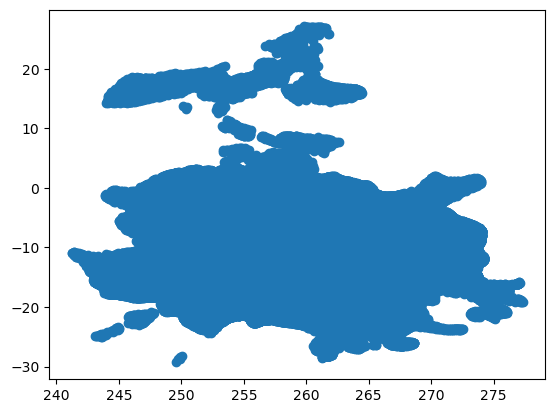

In [94]:
plt.scatter(boundary_out['l[deg]'],boundary_out['b[deg]'])

### Refined sigma loop

In [116]:
np.linspace(350, 950, 5)

array([350., 500., 650., 800., 950.])

In [7]:
# boundary_out = boundary_out_re
boundary_out = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/outer_boundary_350_sigma_500.csv')
sigma = stepsize**2/(350/500)
boundary_out_re = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
sigma0 = sigma

In [8]:
sigma = stepsize**2/(350/350)
for p in tqdm(range(density_lines.shape[1])):
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
    d1 = np.gradient(gau_1D_dens, dist)
    d2 = np.gradient(d1,dist)
    pos_inflection = np.where(d1>0)
    neg_inflection = np.where(d1<0)
    zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
    inf_indices_pos = np.intersect1d(zero_inds, pos_inflection)
    inf_indices_neg = np.intersect1d(zero_inds, neg_inflection)
    inf_ind_closest = inf_indices_neg[np.abs(dist[inf_indices_neg] - boundary_out.iloc[p]['r_raw']).argmin()] #106 for this case
    if (dist[inf_ind_closest]>boundary_out.iloc[p]['r_raw']-sigma0) and (dist[inf_ind_closest]<boundary_out.iloc[p]['r_raw']+sigma0):
        inflection_i = inf_ind_closest
        inflection_dist = dist[inflection_i]
    else:
        inflection_dist = boundary_out.iloc[p]['r_raw']
        inflection_i = np.abs(dist-inflection_dist).argmin()  #np.where(dist==inflection_dist)[0][0]

    inf_z, inf_y, inf_x = stepsize*(loc[p, :, inflection_i]-[165,345,145]) #coordinate in the xyz frame
    galactic_lbd = SkyCoord(x = inf_x*u.pc, y = inf_y*u.pc, z = inf_z*u.pc, representation='cartesian').spherical
    boundary_out_re.loc[len(boundary_out_re)] = [inf_x, inf_y, inf_z, galactic_lbd.lon.value, galactic_lbd.lat.value, 
                                                 galactic_lbd.distance.value, p, inflection_dist]

100%|██████████████████████████████████| 196608/196608 [07:50<00:00, 417.71it/s]


In [9]:
boundary_out_re.to_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/outer_boundary_350_sigma_350.csv', index=False)

inf_indices_pos: [ 38 265]
dist[pos]: [ 38.10888252 265.75931232]
inf_indices_neg: [106 148 172 326]
dist[neg]: [106.30372493 148.42406877 172.49283668 326.93409742]
inf_ind_closest: 106
a
106.30372492836676


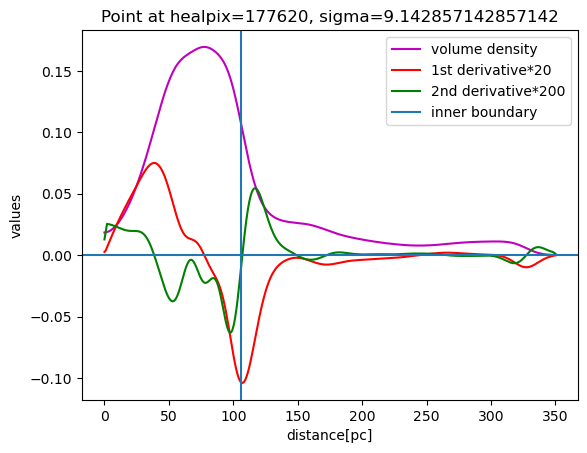

In [225]:

# boundary_out=boundary_out_re
# boundary_out_re = pd.DataFrame(columns=['x[pc]', 'y[pc]', 'z[pc]', 'l[deg]', 'b[deg]', 'd[pc]','index', 'r_raw'])
sigma=stepsize**2/(350/950) 
sigma0 = sigma
sigma = stepsize**2/(350/800)
gau_1D_dens = gaussian_filter1d(density_lines[str(p)].tolist(), sigma)
d1 = np.gradient(gau_1D_dens, dist)
d2 = np.gradient(d1,dist)
pos_inflection = np.where(d1>0)
neg_inflection = np.where(d1<0)
zero_inds = np.where(np.diff(np.sign(d2))!= 0)[0]
inf_indices_pos = np.intersect1d(zero_inds, pos_inflection)
inf_indices_neg = np.intersect1d(zero_inds, neg_inflection)

print('inf_indices_pos:',inf_indices_pos)
print('dist[pos]:', dist[inf_indices_pos])
print('inf_indices_neg:',inf_indices_neg)
print('dist[neg]:', dist[inf_indices_neg])
inf_ind_closest = inf_indices_neg[np.abs(dist[inf_indices_neg] - boundary_out.iloc[p]['r_raw']).argmin()] #106 for this case
print('inf_ind_closest:',inf_ind_closest)
if (dist[inf_ind_closest]>boundary_out.iloc[p]['r_raw']-sigma0) and (dist[inf_ind_closest]<boundary_out.iloc[p]['r_raw']+sigma0):
    inflection_i = inf_ind_closest
    inflection_dist = dist[inflection_i]
    print('a')
else:
    inflection_dist=boundary_out.iloc[p]['r_raw']
print(inflection_dist)
plt.plot(dist, gau_1D_dens, 'm', label='volume density')
plt.plot(dist, d1*20, 'r', label='1st derivative*20')
plt.plot(dist, d2*200, 'g', label='2nd derivative*200')
# plt.xlim(0,150)
# plt.ylim(-0.2,0.2)
plt.axhline(0)
plt.axvline(dist[inflection_i], label = 'inner boundary')
# plt.scatter(inner.iloc[p]['r_raw'], 0, label='inner boundary distance')
# plt.scatter(outer.iloc[p]['r_raw'], 0, label='outer boundary distance')
plt.xlabel('distance[pc]')
plt.ylabel('values')
plt.title(f'Point at healpix={ip}, sigma={sigma}')
plt.legend()
# plt.grid()
plt.show()

# Check the thickness & mass of the shell

In [86]:
sigma_in = 650 #800
inner = pd.read_csv(f'/Users/anniegao/Dropbox/Gum_Nebula/data/boundary_Gum_edenhofer_center2_new_sigma_{sigma_in}.csv')
# inner = pd.read_csv(f'/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/boundary_Gum_edenhofer_center2_new_sigma_{sigma_in}.csv')
# inner = boundary

In [38]:
sub_lid = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/sub.csv') #only the 'index' is meaningful

In [36]:
sub_mask = np.isin(sub['index'], sub_lid["index"])
lid_th = sub[sub_mask]

In [29]:
sub['index']=sub.index.values

No handles with labels found to put in legend.


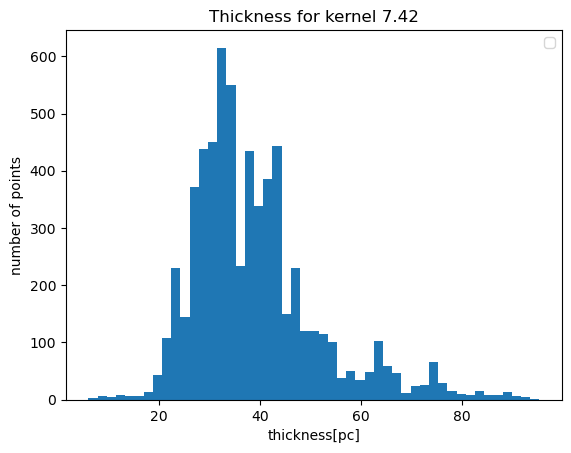

mean: 38.97146135444746 std: 12.786415152163482


In [37]:
bins = np.linspace(np.min(lid_th['r_raw'].values),np.max(lid_th['r_raw'].values), 50)
th_mean = np.mean(lid_th['r_raw'])
th_std = np.std(lid_th['r_raw'])
plt.hist(lid_th['r_raw'], bins=bins)
plt.xlabel('thickness[pc]')
plt.ylabel('number of points')
plt.title(f'Thickness for kernel 7.42')
plt.legend()
plt.show()
print('mean:', th_mean, 'std:', th_std)

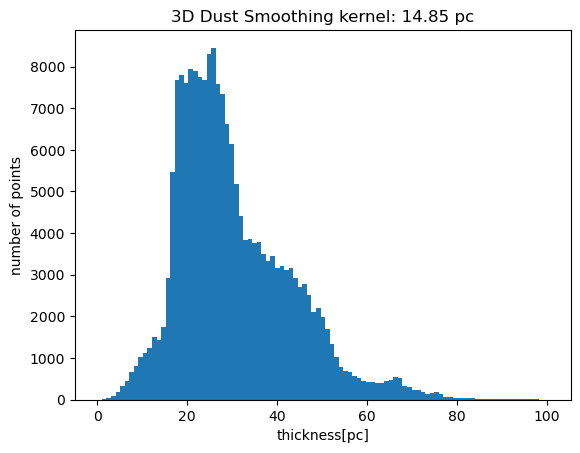

mean: 30.578068220408145 std: 12.671649894653076


In [48]:
bins = np.linspace(1e-7,np.max(sub['r_raw'].values), 100)
th_mean = np.mean(sub['r_raw'])
th_std = np.std(sub['r_raw'])
plt.hist(sub['r_raw'], bins=bins)
plt.xlabel('thickness[pc]')
plt.ylabel('number of points')
# plt.ylim(0, 1000)
plt.title(f'3D Dust Smoothing kernel: 14.85 pc')  #\delta_mean \delta_std = 32 pc, 12 pc
# plt.legend()
plt.show()
print('mean:', th_mean, 'std:', th_std)

In [80]:
2*2*2/(350/500)

11.428571428571429

In [87]:
sigma_out = 650
outer = pd.read_csv(f'/Users/anniegao/Dropbox/Gum_Nebula/data/outer_boundary_350_sigma_{sigma_out}.csv')
# outer = pd.read_csv(f'/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/outer_boundary_350_sigma_{sigma_out}.csv')

# outer = boundary_out

In [56]:
sub

,x[pc],y[pc],z[pc],l[deg],b[deg],d[pc],index,r_raw
0,0.221649,0.221649,49.139401,0.029368,7.653121,13.332414,0.0,49.140401
1,-0.194508,0.194508,43.122332,-0.038639,6.730023,11.543845,0.0,43.123209
2,-0.203555,-0.203555,45.128022,-0.026698,6.967300,12.767014,0.0,45.128940
3,0.212602,-0.212602,47.133712,0.041949,7.273705,13.384735,0.0,47.134670
4,0.602828,0.249700,51.141970,0.091776,7.961881,13.931369,0.0,51.146132
...,...,...,...,...,...,...,...,...
196603,0.543728,-0.225219,-46.128051,0.097049,-6.986520,14.500115,0.0,46.131805
196604,0.208079,0.208079,-46.130867,0.027471,-7.010764,14.174094,0.0,46.131805
196605,-0.208079,0.208079,-46.130867,-0.041238,-7.005322,14.248628,0.0,46.131805
196606,-0.208079,-0.208079,-46.130867,-0.027390,-6.978294,14.619710,0.0,46.131805


mean: 30.578068220408145 std: 12.671649894653076


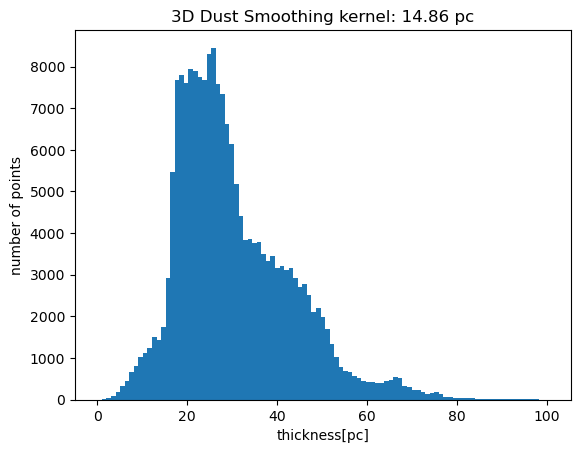

 mean 30.58, std 12.67


In [89]:
sigma = 2*(2*2/(350/sigma_out))
sub = outer-inner
th_mean =  np.mean(sub['r_raw'])
th_std = np.std(sub['r_raw'])
bins = np.linspace(1e-7,np.max(sub['r_raw'].values), 100)
plt.hist(sub['r_raw'], bins=bins)
plt.xlabel('thickness[pc]')
plt.ylabel('number of points')
plt.title(f'3D Dust Smoothing kernel: {sigma :.2f} pc')
# plt.legend()
print('mean:', th_mean, 'std:', th_std)
plt.show()
# plt.savefig(f'/Users/anniegao/Desktop/sigma{sigma :.0f}.png')
print(f' mean {th_mean:.2f}, std {th_std:.2f}')

## <font color='9357C2'> Mass of the bowl </font>

In [7]:
voxel_value = np.empty((0, 3), dtype=int)
for p in tqdm(range(len(inner))):
# identify voxels along each line of sight:
    x1 = loc[p, 2, :]- xG_p
    y1 = loc[p, 1, :]- yG_p
    z1 = loc[p, 0, :]- zG_p
    dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
    ind_in = np.abs(dist - inner.iloc[p]['r_raw']).argmin()
    ind_out = np.abs(dist - outer.iloc[p]['r_raw']).argmin()
    zyx_p = loc[p,:, ind_in:ind_out].astype('int')
    voxel_value = np.vstack((voxel_value, np.unique(zyx_p.T, axis=0)))

100%|██████████████████████████████████| 196608/196608 [09:25<00:00, 347.84it/s]


In [8]:
voxel_value = np.unique(voxel_value, axis=0)

In [9]:
# np.save('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/voxel_values_800.npy', voxel_value)

In [7]:
voxel_value_650 = np.load('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/voxel_values_650.npy')

In [9]:
voxel_value_650.shape

(338052, 3)

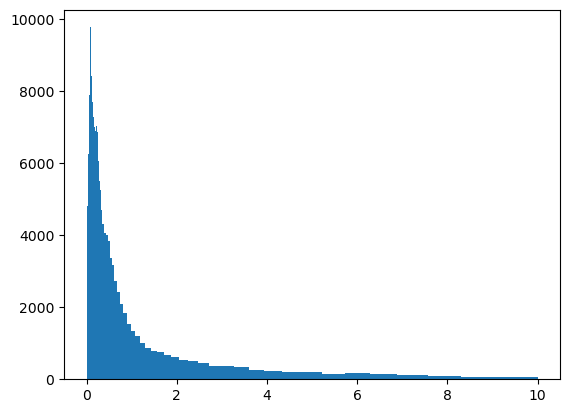

In [36]:
# bins = np.linspace(0, 0.003*826.670, 100)
bins = np.geomspace(1e-3, 1e1, 100)
plt.hist(dust_map_col, bins=bins)
# plt.semilogy()
plt.show()

In [3]:
voxel_mask_650 = pd.DataFrame(columns=['x[pixel]','y[pixel]','z[pixel]'])
voxel_mask_650['x[pixel]']=voxel_value_650.T[2]
voxel_mask_650['y[pixel]']=voxel_value_650.T[1]
voxel_mask_650['z[pixel]']=voxel_value_650.T[0]
# voxel_mask_500 = pd.DataFrame(columns=['x[pixel]','y[pixel]','z[pixel]'])
# voxel_mask_500['x[pixel]']=voxel_value.T[2]
# voxel_mask_500['y[pixel]']=voxel_value.T[1]
# voxel_mask_500['z[pixel]']=voxel_value.T[0]
# voxel_mask_350 = pd.DataFrame(columns=['x[pixel]','y[pixel]','z[pixel]'])
# voxel_mask_350['x[pixel]']=voxel_value.T[2]
# voxel_mask_350['y[pixel]']=voxel_value.T[1]
# voxel_mask_350['z[pixel]']=voxel_value.T[0]
# voxel_mask_800 = pd.DataFrame(columns=['x[pixel]','y[pixel]','z[pixel]'])
# voxel_mask_800['x[pixel]']=voxel_value.T[2]
# voxel_mask_800['y[pixel]']=voxel_value.T[1]
# voxel_mask_800['z[pixel]']=voxel_value.T[0]

In [68]:
print(voxel_value_650.shape)
print(voxel_mask_500.shape)

(338052, 3)
(328194, 3)


In [17]:
print(voxel_mask_350.shape)

(321312, 3)


In [15]:
print(voxel_mask_800.shape)

(350731, 3)


In [16]:
voxel_mask_800.to_csv('~/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/xyz_800.csv',index=False)

$M = \Sigma d M_{i} = \Sigma 1.37 m_{p} \times n_{i} \times dV_{i}$ \
dust_map unit in [pc], convert from column density $(cm^{-3})$ to $(2pc)^{-3}$ by multiplying $(2*3.086*10^{18})^{3}$,
convert to solar mass by dividing $1.989*10^{30}$

In [29]:
# make the mask: let dust map voxel value 650 = 1, other =0
dust_map_mask = dust_map.copy()
dust_map_mask[:, :, :] = 0
for i in range(len(voxel_value_650)):
    dust_map_mask[tuple(voxel_value_650[i])]=1

In [33]:
# hdu = fits.PrimaryHDU(dust_map_mask, header=f[0].header)
# hdul = fits.HDUList([hdu])
# hdul.writeto('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/edenhofer_2023/shell_mask_650.fits')

In [35]:
col_den = 0
for i in tqdm(range(len(voxel_value_650))):
    col_den += dust_map[tuple(voxel_value_650[i])]
    
col_den *= 826.670

100%|██████████████████████████████| 338052/338052 [00:00<00:00, 1457767.16it/s]


In [37]:
#for 650
m_proton = 1.67262192e-27 #[kg]
mass_phy = 1.37*m_proton*col_den*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy:.3e}")

2.840e+04


In [12]:
# for 500 & 350 & 800
col_den = 0
for i in tqdm(range(len(voxel_value))):
    col_den += dust_map[tuple(voxel_value[i])]
    
col_den *= 826.670

100%|██████████████████████████████| 350731/350731 [00:00<00:00, 1283892.47it/s]


In [60]:
# for 500
m_proton = 1.67262192e-27 #[kg]
mass_phy = 1.37*m_proton*col_den*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy:.3e}")

2.727e+04


In [22]:
# for 350
m_proton = 1.67262192e-27 #[kg]
mass_phy = 1.37*m_proton*col_den*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy:.3e}")

2.611e+04


In [13]:
# for 800
m_proton = 1.67262192e-27 #[kg]
mass_phy = 1.37*m_proton*col_den*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy:.3e}")

2.953e+04


###  <font color= '1E90FF'>  Only the bottom part of the Vela shell </font>

In [17]:
bowl_list = pd.read_csv('/Users/anniegao/Documents/dustmaps_files/Dust_maps/Edenhofer_map_sketch/new_dustmap/xyz_800_bowl.csv').to_numpy()

In [47]:
#for 650 bowl
col_den_bowl = 0
for i in tqdm(range(len(bowl_list))):
    col_den_bowl += dust_map[tuple(bowl_list[i])]
col_den_bowl *= 826.670

100%|██████████████████████████████| 282307/282307 [00:00<00:00, 1235035.23it/s]


In [48]:
mass_phy_bowl = 1.37*m_proton*col_den_bowl*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy_bowl:.3e}")

1.964e+04


In [71]:
#for 500 bowl
col_den_bowl = 0
for i in tqdm(range(len(bowl_list))):
    col_den_bowl += dust_map[tuple(bowl_list[i])]
col_den_bowl *= 826.670

mass_phy_bowl = 1.37*m_proton*col_den_bowl*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy_bowl:.3e}")

100%|██████████████████████████████| 274046/274046 [00:00<00:00, 1239276.03it/s]

1.872e+04


In [24]:
#for 350 bowl
col_den_bowl = 0
for i in tqdm(range(len(bowl_list))):
    col_den_bowl += dust_map[tuple(bowl_list[i])]
col_den_bowl *= 826.670

mass_phy_bowl = 1.37*m_proton*col_den_bowl*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy_bowl:.3e}")

100%|██████████████████████████████| 268354/268354 [00:00<00:00, 1225533.61it/s]

1.793e+04


In [18]:
#for 800 bowl
col_den_bowl = 0
for i in tqdm(range(len(bowl_list))):
    col_den_bowl += dust_map[tuple(bowl_list[i])]
col_den_bowl *= 826.670

mass_phy_bowl = 1.37*m_proton*col_den_bowl*(2*3.086e+18)**3/(1.989e+30) #pc3 to cm3
print(f"{mass_phy_bowl:.3e}")

100%|██████████████████████████████| 293138/293138 [00:00<00:00, 1235221.55it/s]

2.070e+04


In [20]:
#experiment to use no loop, not working
# x1 = loc[:, 2, :]- xG_p
# y1 = loc[:, 1, :]- yG_p
# z1 = loc[:, 0, :]- zG_p
# dist = np.sqrt(x1**2+ y1**2+ z1**2)*stepsize
# ind_in = np.abs(dist-inner['r_raw'].values[:,None]).argmin(axis=1)
# ind_out = np.abs(dist-outer['r_raw'].values[:,None]).argmin(axis=1)
# inds = np.column_stack((ind_in, ind_out))
# zyx_p = loc[:,:, ind_in:ind_out].astype('int')